In [ ]:
"""
l3s4a: per day and all day correlation and other associated analyses of subjective and objective measures (TET and wristband derived respectively)

PART - 1

Combination of l3s2 and l3s3 for subjective and objective measures (TET and wristband per min aggr data derived respectively)

1. Load the script with subjective dimensions like in l3s2 until the big dictionary step.
2. Similarly, load per min agg objective values like in l3s3 until the big dictionary step.
3. Combine the two dictionaries by matching the key values (the days)
4. Correlate all of them with one another and output into corellogram for per day and all day and both with fdr correction - they should all be matched by the same 15 minute bins


PART - 2

Any other useful analyses and visualisations
"""


In [2]:
#Imports and major functions


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from scipy.stats import shapiro
from scipy.stats import kendalltau
from statsmodels.stats.multitest import multipletests
import seaborn as sns

from l2script_functions import giv_x_y_vals, give_binned_vals, give_binned_vals_category

import warnings
import datetime
from datetime import datetime
import pytz


"""
define binning function for objective measures
"""
def give_binned_vals_obj_meas(df, obj_meas, hour, half_hour, quarter_hour, timezone, category_yn = False):
    
    bin_dict = {}
    bin_dict_scl = {}
    bin_dict_scr = {}

    #only for objective measures, include the extra hour of data (if in cet)
    if category_yn:
        bin_arr = np.arange(0,25,6)
    elif hour: #hour seperation
        bin_arr = np.arange(0,25)
    elif half_hour: #half hour seperation
        bin_arr = np.arange(0,24.5, 0.5)
    elif quarter_hour: #quarter hour seperation
        bin_arr = np.arange(0,24.25, 0.25)
    # Defining the time zones
    utc_zone = pytz.utc
    req_zone = pytz.timezone(timezone)
    
    #if aggr_p_min data, time conversion block (add an extra column to the dataframe with required timezone timestamps)
    def from_isoutc_to_req(iso_timestamp):
            #Parsing the ISO 8601 timestamp into a datetime object
            utc_time = datetime.fromisoformat(iso_timestamp.replace("Z", "+00:00"))
    
            #Converting from utc to required (cet) time
            req_time = utc_time.astimezone(req_zone)
            #print(req_time, type(req_time))
    
            return req_time 

    # Apply the conversion function to the 'utc_timestamps' column and create a new column 'converted_timestamps'
    df['converted_timestamps'] = df['timestamp_iso'].apply(from_isoutc_to_req)

    first_day = df['converted_timestamps'].iloc[0].day 

    x_val = df['converted_timestamps'].apply(
        lambda x: (24 + int(str(x).split()[1].split(':')[0]) + int(str(x).split()[1].split(':')[1])/60) 
        if x.day > first_day 
        else (int(str(x).split()[1].split(':')[0]) + int(str(x).split()[1].split(':')[1])/60)
    ).tolist()

    """
    #Optional, not used so far
    #range of permissible eda range
    min_val = 0.05
    max_val = 60
    #yes but what about scl specifically??? -> haven't found a source talking about scl permissible ranges so for now set this aside
    """
    if obj_meas == 'eda':
        y_val = df['eda_scl_usiemens'].tolist()
    elif obj_meas == 'pulse_rate':
        y_val = df['pulse_rate_bpm'].tolist()
    elif obj_meas == 'prv':
        y_val = df['prv_rmssd_ms'].tolist()
    elif obj_meas == 'resp_rate':
        y_val = df['respiratory_rate_brpm'].tolist()
    elif obj_meas == 'temp':
        y_val = df['temperature_celsius'].tolist()
    elif obj_meas == 'step_count':
        y_val = df['step_counts'].tolist()
    elif obj_meas == 'acc_std':
        y_val = df['accelerometers_std_g'].tolist()
    elif obj_meas == 'activity_counts':
        y_val = df['activity_counts'].tolist()
    elif obj_meas == 'met':
        y_val = df['met'].tolist() 
    elif obj_meas == 'wearing_det':
        y_val = df['wearing_detection_percentage'].tolist()
    ###Optional: include measures after review
    
    for i in range(0, len(bin_arr) - 1):
            #Create the key for the dictionary
            key = str(bin_arr[i]) + '_' + str(bin_arr[i+1])
    
            #Initialize an empty list for this key
            templst = []
            bin_dict[key] = templst
        
            #Iterate over x_val, append to templst if condition is met
            for j in range(0, len(x_val)):
                if x_val[j] >= bin_arr[i] and x_val[j] < bin_arr[i+1] and x_val[j]<bin_arr[-1]: 
                    #Appending y_val[j] directly to the list in the dictionary
                    bin_dict[key].append(y_val[j])
                if x_val[j]>=bin_arr[-1]:
                    #print("not appending value at time: ", x_val[j])
                    continue

    #for conversion of lists to numpy arrays
    for key in bin_dict:
            bin_dict[key] = np.array(bin_dict[key])
            #print(bin_dict)

    bin_dict_mean = {}
    for key in bin_dict:
            if np.all(np.isnan(bin_dict[key])):
                #print('list only has nan values')
                bin_dict_mean[key] = np.nan
            elif ~np.all(np.isnan(bin_dict[key])) and len(bin_dict[key])!=0:
                #print('list is not empty')
                bin_dict_mean[key] = np.nanmean(bin_dict[key]) 
            else:
                print('-5000 has been appended') #this print statement added to debug if there is ever a situation where this would happen (technically it shouldn't)
                bin_dict_mean[key] = -5000

    return  df['converted_timestamps'], x_val, y_val, bin_dict_mean 

[NbConvertApp] Converting notebook l2script_functions.ipynb to script
[NbConvertApp] Writing 87159 bytes to l2script_functions.py


In [ ]:
#some more common global variable definitions

folder1 = 'empatica'
folder2 = 'saved_figures'

folder11 = 'aggr_p_min'
folder12 = 'avro_files'
folder13 = 'avro2csv'
folder14 = 'preprocessed_files_debug'
folder141 = 'data_preproc_debug'

ger = True #if country of data collection is Germany, true, else (if UK, false) -> because language of TET questions and other input data config changes by country
timezone = 'Europe/Berlin' # 'utc' #default timezone; enter required timezone if different
mainfolder = input('enter participant folder: ')

In [52]:
dict_TET_x1, dict_TET_y1,  x_new1, y_new1, x1, y1 = giv_x_y_vals(mainfolder, 'q1', ger) #has duplicates (asd_001)
dict_TET_x2, dict_TET_y2,  x_new2, y_new2, x2, y2 = giv_x_y_vals(mainfolder, 'q2', ger) #has duplicates and days with missing data (asd_001)
dict_TET_x3, dict_TET_y3,  x_new3, y_new3, x3, y3 = giv_x_y_vals(mainfolder, 'q3', ger) #has duplicates (hc_002) #has days with missing data (asd_001)
dict_TET_x4, dict_TET_y4,  x_new4, y_new4, x4, y4 = giv_x_y_vals(mainfolder, 'q4', ger) #has days with missing data (asd_001)
dict_TET_x5, dict_TET_y5,  x_new5, y_new5, x5, y5 = giv_x_y_vals(mainfolder, 'q5', ger) #has duplicates and days with missing data (asd_001)
dict_TET_x6, dict_TET_y6,  x_new6, y_new6, x6, y6 = giv_x_y_vals(mainfolder, 'q6', ger) #has duplicates (hc_002) #has days with missing data (asd_001)
dict_TET_x7, dict_TET_y7,  x_new7, y_new7, x7, y7 = giv_x_y_vals(mainfolder, 'q7', ger)
dict_TET_x8, dict_TET_y8,  x_new8, y_new8, x8, y8 = giv_x_y_vals(mainfolder, 'q8', ger) #has duplicates and days with missing data (asd_001) -> but for the day that it had duplicate data (15_3_24_n7_16_3_24_d) the data was identical so all good
dict_TET_x9, dict_TET_y9,  x_new9, y_new9, x9, y9 = giv_x_y_vals(mainfolder, 'q9', ger) #has duplicates (hc_002) #has days with missing data (asd_001)


04_11_23_n1_5_11_23_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  2
yes 9
05_11_23_n2_6_11_23_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  2
yes 8
06_11_23_n3_7_11_23_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  1
yes 9
07_11_23_n4_8_11_23_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  6
yes 8
08_11_23_n5_9_11_23_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  2
yes 8
09_11_23_n6_10_11_23_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  2
yes 9
10_11_23_n7_11_11_23_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  2
yes 8
11_11_23_n8_12_11_23_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct ind

In [53]:
#Now, obtain the binned dictionaries for each dimension

dict_TET_x = [dict_TET_x1, dict_TET_x2, dict_TET_x3, dict_TET_x4, dict_TET_x5, dict_TET_x6, dict_TET_x7, dict_TET_x8, dict_TET_x9]
dict_TET_y = [dict_TET_y1, dict_TET_y2, dict_TET_y3, dict_TET_y4, dict_TET_y5, dict_TET_y6, dict_TET_y7, dict_TET_y8, dict_TET_y9]

dim_q = {}

#pairing up the names of the dimensions for added info
dim_names = ['wakefullness', 'boredom', 'sensory_avoidance', 'social avoidance', 'physical tension', 'scenario_anxiety', 'rumination', 'stress', 'pain'] #can add 'personalised_dimension' as and when it becomes applicable. But most of the times, data is not available
for i in range(9):
    dim_q[f'dim_{i+1}_{dim_names[i]}'] = {}
    for key in dict_TET_x[i]:
        x_val = dict_TET_x[i][key] * 6
        y_val = dict_TET_y[i][key]
        dim_q[f'dim_{i+1}_{dim_names[i]}'][key] = give_binned_vals(x_val, y_val, '15')

In [54]:
#now for each day, assess each dimension array for normality using shapiro wilk and generate correlograms (pearson and kendall). add an indication for every significant test statistic (p<0.05)

#step 1: for every day, every available dimension assessed for normality and reported in a single dictionary or dataframe

norm_res = {}
for subfolder in os.listdir(mainfolder):
    if subfolder.endswith('d'):
        for i in range(9):
            if subfolder in dim_q[f'dim_{i+1}_{dim_names[i]}'].keys():
                #print('yes ', subfolder,  f'dim_{i+1}_{dim_names[i]}')
                filt_dict = {key: value for key, value in dim_q[f'dim_{i+1}_{dim_names[i]}'][subfolder].items() if value != -5000}
                #print(filt_dict)
                if subfolder not in norm_res:
                        norm_res[subfolder] = {}
                if f'dim_{i+1}_{dim_names[i]}' not in norm_res[subfolder]:
                        norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}'] = {}
                    
                if len(filt_dict) >= 3:
                    stat, p_value = shapiro(list(filt_dict.values()))
                    #print(stat, p_value)
                    
                    
                    norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}']['length of data'] = len(list(filt_dict.values()))
                    norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}']['stat'] = stat
                    norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}']['p_value'] = p_value
                    norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}']['full data'] = dim_q[f'dim_{i+1}_{dim_names[i]}'][subfolder]
                else:
                    norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}']['length of data'] = len(list(filt_dict.values()))
                    norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}']['stat'] = None
                    norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}']['p_value'] = None  # Not enough data for the test
                    norm_res[subfolder][f'dim_{i+1}_{dim_names[i]}']['full data'] = dim_q[f'dim_{i+1}_{dim_names[i]}'][subfolder]

In [55]:
eda_dict_plot_x = {}
eda_dict_plot_y = {}
eda_dict_bin = {}
pulse_rate_dict_plot_x = {}
pulse_rate_dict_plot_y = {}
pulse_rate_dict_bin = {}
prv_dict_plot_x = {}
prv_dict_plot_y = {}
prv_dict_bin = {}
resp_rate_dict_plot_x = {}
resp_rate_dict_plot_y = {}
resp_rate_dict_bin = {}
temp_dict_plot_x = {}
temp_dict_plot_y = {}
temp_dict_bin = {}
step_dict_plot_x = {}
step_dict_plot_y = {}
step_dict_bin = {}
acc_std_dict_plot_x = {}
acc_std_dict_plot_y = {}
acc_std_dict_bin = {}
activity_dict_plot_x = {}
activity_dict_plot_y = {}
activity_dict_bin = {}
met_dict_plot_x = {}
met_dict_plot_y = {}
met_dict_bin = {}
wearing_det_dict_plot_x = {}
wearing_det_dict_plot_y = {}
wearing_det_dict_bin = {}



#in the lines below, take out "_converted_timestamp," variables after timestamp verification check
eda_converted_timestamp = {}
pulse_rate_converted_timestamp = {}
prv_converted_timestamp = {}
resp_rate_converted_timestamp = {}
temp_converted_timestamp = {}
step_converted_timestamp = {}
acc_converted_timestamp = {}
activity_converted_timestamp = {}
met_converted_timestamp = {}
wearing_det_converted_timestamp = {}

#storing the dates for which the variables are recorded. Required for time-stitching
eda_dates = []
pulse_rate_dates = []
prv_dates = []
resp_rate_dates = []
temp_dates = []
step_dates = []
acc_std_dates = []
activity_dates = []
met_dates = []
wearing_det_dates = []


for subfolder in os.listdir(mainfolder):
    if subfolder.endswith('d') and os.path.exists(os.path.join(mainfolder, subfolder, folder1, folder11)):
        print(subfolder)
        for file in os.listdir(os.path.join(mainfolder, subfolder, folder1, folder11)):
            if file.endswith('eda.csv'):
                eda_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                eda_converted_timestamp[subfolder], eda_dict_plot_x[subfolder], eda_dict_plot_y[subfolder], eda_dict_bin[subfolder] = give_binned_vals_obj_meas(eda_df, 'eda', False, False, True, timezone)
                eda_dates.append(subfolder)
            
            elif file.endswith('pulse-rate.csv'):
                pulse_rate_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                pulse_rate_converted_timestamp[subfolder], pulse_rate_dict_plot_x[subfolder], pulse_rate_dict_plot_y[subfolder], pulse_rate_dict_bin[subfolder] = give_binned_vals_obj_meas(pulse_rate_df, 'pulse_rate', False, False, True, timezone)
                pulse_rate_dates.append(subfolder)
            
            elif file.endswith('prv.csv'):
                prv_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                prv_converted_timestamp[subfolder], prv_dict_plot_x[subfolder], prv_dict_plot_y[subfolder], prv_dict_bin[subfolder] = give_binned_vals_obj_meas(prv_df, 'prv', False, False, True, timezone)
                prv_dates.append(subfolder)
                
            elif file.endswith('respiratory-rate.csv'):
                resp_rate_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                resp_rate_converted_timestamp[subfolder], resp_rate_dict_plot_x[subfolder], resp_rate_dict_plot_y[subfolder], resp_rate_dict_bin[subfolder] = give_binned_vals_obj_meas(resp_rate_df, 'resp_rate', False, False, True, timezone)
                resp_rate_dates.append(subfolder)
            
            elif file.endswith('temperature.csv'):
                temp_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                temp_converted_timestamp[subfolder], temp_dict_plot_x[subfolder], temp_dict_plot_y[subfolder], temp_dict_bin[subfolder] = give_binned_vals_obj_meas(temp_df, 'temp', False, False, True, timezone)
                temp_dates.append(subfolder)
            
            elif file.endswith('step-counts.csv'):
                step_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                step_converted_timestamp[subfolder], step_dict_plot_x[subfolder], step_dict_plot_y[subfolder], step_dict_bin[subfolder] = give_binned_vals_obj_meas(step_df, 'step_count', False, False, True, timezone)
                step_dates.append(subfolder)
                
            elif file.endswith('accelerometers-std.csv'):
                acc_std_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                acc_converted_timestamp[subfolder], acc_std_dict_plot_x[subfolder], acc_std_dict_plot_y[subfolder], acc_std_dict_bin[subfolder] = give_binned_vals_obj_meas(acc_std_df, 'acc_std', False, False, True, timezone)
                acc_std_dates.append(subfolder)
                
            elif file.endswith('activity-counts.csv'):
                activity_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                activity_converted_timestamp[subfolder], activity_dict_plot_x[subfolder], activity_dict_plot_y[subfolder], activity_dict_bin[subfolder] = give_binned_vals_obj_meas(activity_df, 'activity_counts', False, False, True, timezone)
                activity_dates.append(subfolder)
            
            elif file.endswith('met.csv'):
                met_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                met_converted_timestamp[subfolder], met_dict_plot_x[subfolder], met_dict_plot_y[subfolder], met_dict_bin[subfolder] = give_binned_vals_obj_meas(met_df, 'met', False, False, True, timezone)
                met_dates.append(subfolder)
            
            elif file.endswith('wearing-detection.csv'):
                wearing_det_df = pd.read_csv(os.path.join(mainfolder, subfolder, folder1, folder11, file))
                wearing_det_converted_timestamp[subfolder], wearing_det_dict_plot_x[subfolder], wearing_det_dict_plot_y[subfolder], wearing_det_dict_bin[subfolder] = give_binned_vals_obj_meas(wearing_det_df, 'wearing_det', False, False, True, timezone)
                wearing_det_dates.append(subfolder)                
    #(df, obj_meas, hour, half_hour, quarter_hour, timezone):
    
                
            

04_11_23_n1_5_11_23_d
05_11_23_n2_6_11_23_d
06_11_23_n3_7_11_23_d
07_11_23_n4_8_11_23_d
08_11_23_n5_9_11_23_d
09_11_23_n6_10_11_23_d
10_11_23_n7_11_11_23_d
11_11_23_n8_12_11_23_d
12_11_23_n9_13_11_23_d
13_11_23_n10_14_11_23_d
14_11_23_n11_15_11_23_d
15_11_23_n12_16_11_23_d
16_11_23_n13_17_11_23_d
17_11_23_n14_18_11_23_d
18_11_23_n15_19_11_23_d
19_11_23_n16_20_11_23_d


In [57]:
#additional function for timestitch
def process_time_values(non_cont_dates, dates_list, dict_plot_x, dict_plot_y):
    """
    Process time values to move data points with x >= 24 to the next day.
    Also creates binned data and calculates bin means for each date.
    
    Parameters:
    non_cont_dates (list): List of dates that are not continuous i.e; dates where the next night is not the very next date but further off. 
    dates_list (list): List of dates for the specific measure
    dict_plot_x (dict): Dictionary with dates as keys and x-values as values
    dict_plot_y (dict): Dictionary with dates as keys and y-values as values
    
    Returns:
    tuple: Modified dict_plot_x, dict_plot_y dictionaries, and bin_dict_mean (nested dictionary)
    """
        
    # Creating copies to avoid modifying the originals directly
    modified_dict_x = {k: v.copy() for k, v in dict_plot_x.items()}
    modified_dict_y = {k: v.copy() for k, v in dict_plot_y.items()}
    
    for i in range(0, len(dates_list)):
        current_date = dates_list[i]
        
        if current_date in non_cont_dates:
            # Discarding values in dict_plot_x[current_date] that are >= 24 and also corresponding values in dict_plot_y[current_date]
            indices_to_remove = [idx for idx, x_val in enumerate(modified_dict_x[current_date]) if x_val >= 24]
            
            # Removing these values from both x and y arrays (in reverse order to avoid index shifts)
            for idx in sorted(indices_to_remove, reverse=True):
                modified_dict_x[current_date].pop(idx)
                modified_dict_y[current_date].pop(idx)

            print(f"Warning: Discarding values >=24 for the this date {current_date} as it is listed in non_cont_dates.")
        else:
            #Checking if this isn't the last date
            if i + 1 < len(dates_list):
                next_date = dates_list[i+1]
                print(current_date, next_date)
                # Finding indices where x values are >= 24
                indices_to_move = [idx for idx, x_val in enumerate(modified_dict_x[current_date]) if x_val >= 24]
                
                if indices_to_move:  # Only process if there are values to move
                    #Values to be moved
                    x_values_to_move = [modified_dict_x[current_date][idx] - 24 for idx in indices_to_move]  # Subtract 24
                    y_values_to_move = [modified_dict_y[current_date][idx] for idx in indices_to_move]
                    
                    #Adding these values to the next day's data
                    modified_dict_x[next_date] = x_values_to_move + modified_dict_x[next_date]
                    modified_dict_y[next_date] = y_values_to_move + modified_dict_y[next_date]
                    
                    #Removing these values from the current day (in reverse order to avoid index shifts)
                    for idx in sorted(indices_to_move, reverse=True):
                        modified_dict_x[current_date].pop(idx)
                        modified_dict_y[current_date].pop(idx)
            else:
                #This is the last date, so we can't move values to the next day
                print(f"Warning: Discarding values >=24 for the last date {current_date} as there's no next day.")
                indices_to_remove = [idx for idx, x_val in enumerate(modified_dict_x[current_date]) if x_val >= 24]
                
                #Remove these values (in reverse order to avoid index shifts)
                for idx in sorted(indices_to_remove, reverse=True):
                    modified_dict_x[current_date].pop(idx)
                    modified_dict_y[current_date].pop(idx)
    
    # Creating binned data for each date
    bin_dict_mean = {}
    
    # Processing each date separately
    for date in dates_list:
        x_val = modified_dict_x[date]
        y_val = modified_dict_y[date]
        
        # Creating bin dictionary for this date
        bin_dict = {}
        
        # Creating bins
        bin_arr = np.arange(0, 24.25, 0.25) #CAUTION: this has to be updated incase a different binning value is chosen
        
        for i in range(0, len(bin_arr) - 1):
            # Creating the key for the dictionary
            key = str(bin_arr[i]) + '_' + str(bin_arr[i+1])
            
            # Initializing an empty list for this key
            templst = []
            bin_dict[key] = templst
            
            # Iterating over x_val, append to templst if condition is met
            for j in range(0, len(x_val)):
                if x_val[j] >= bin_arr[i] and x_val[j] < bin_arr[i+1] and x_val[j] < bin_arr[-1]:
                    # Appending y_val[j] directly to the list in the dictionary
                    bin_dict[key].append(y_val[j])
                if x_val[j] >= bin_arr[-1]:
                    print(f"Date {date}: not appending value at time: {x_val[j]}")
        
        # Converting lists to numpy arrays
        for key in bin_dict:
            bin_dict[key] = np.array(bin_dict[key])
        
        # Calculating means for this date's bins
        date_bin_dict_mean = {}
        for key in bin_dict:
            if len(bin_dict[key]) == 0:
                date_bin_dict_mean[key] = np.nan
            elif np.all(np.isnan(bin_dict[key])):
                # List only has nan values
                date_bin_dict_mean[key] = np.nan
            elif ~np.all(np.isnan(bin_dict[key])) and len(bin_dict[key]) != 0:
                # List is not empty and contains non-nan values
                date_bin_dict_mean[key] = np.nanmean(bin_dict[key]) 
            else:
                print(f'Date {date}: -5000 has been appended')  # Debug statement
                date_bin_dict_mean[key] = -5000
        
        # Adding this date's bin means to the overall dictionary
        bin_dict_mean[date] = date_bin_dict_mean
    
    return modified_dict_x, modified_dict_y, bin_dict_mean

In [58]:
# Process each measure
non_cont_dates = []  #for asd_001: ["09_3_24_n2_10_3_24_d"] #for hc_002: [] 
eda_dict_plot_x, eda_dict_plot_y, eda_dict_bin = process_time_values(non_cont_dates, eda_dates, eda_dict_plot_x, eda_dict_plot_y)
pulse_rate_dict_plot_x, pulse_rate_dict_plot_y, pulse_rate_dict_bin = process_time_values(non_cont_dates, pulse_rate_dates, pulse_rate_dict_plot_x, pulse_rate_dict_plot_y)
prv_dict_plot_x, prv_dict_plot_y, prv_dict_bin = process_time_values(non_cont_dates, prv_dates, prv_dict_plot_x, prv_dict_plot_y)
resp_rate_dict_plot_x, resp_rate_dict_plot_y, resp_rate_dict_bin = process_time_values(non_cont_dates, resp_rate_dates, resp_rate_dict_plot_x, resp_rate_dict_plot_y)
temp_dict_plot_x, temp_dict_plot_y, temp_dict_bin = process_time_values(non_cont_dates, temp_dates, temp_dict_plot_x, temp_dict_plot_y)
step_dict_plot_x, step_dict_plot_y, step_dict_bin = process_time_values(non_cont_dates, step_dates, step_dict_plot_x, step_dict_plot_y)
acc_std_dict_plot_x, acc_std_dict_plot_y, acc_std_dict_bin = process_time_values(non_cont_dates, acc_std_dates, acc_std_dict_plot_x, acc_std_dict_plot_y)
activity_dict_plot_x, activity_dict_plot_y, activity_dict_bin = process_time_values(non_cont_dates, activity_dates, activity_dict_plot_x, activity_dict_plot_y)
met_dict_plot_x, met_dict_plot_y, met_dict_bin = process_time_values(non_cont_dates, met_dates, met_dict_plot_x, met_dict_plot_y)
wearing_det_dict_plot_x, wearing_det_dict_plot_y, wearing_det_dict_bin = process_time_values(non_cont_dates, wearing_det_dates, wearing_det_dict_plot_x, wearing_det_dict_plot_y)

04_11_23_n1_5_11_23_d 05_11_23_n2_6_11_23_d
05_11_23_n2_6_11_23_d 06_11_23_n3_7_11_23_d
06_11_23_n3_7_11_23_d 07_11_23_n4_8_11_23_d
07_11_23_n4_8_11_23_d 08_11_23_n5_9_11_23_d
08_11_23_n5_9_11_23_d 09_11_23_n6_10_11_23_d
09_11_23_n6_10_11_23_d 10_11_23_n7_11_11_23_d
10_11_23_n7_11_11_23_d 11_11_23_n8_12_11_23_d
11_11_23_n8_12_11_23_d 12_11_23_n9_13_11_23_d
12_11_23_n9_13_11_23_d 13_11_23_n10_14_11_23_d
13_11_23_n10_14_11_23_d 14_11_23_n11_15_11_23_d
14_11_23_n11_15_11_23_d 15_11_23_n12_16_11_23_d
15_11_23_n12_16_11_23_d 16_11_23_n13_17_11_23_d
16_11_23_n13_17_11_23_d 17_11_23_n14_18_11_23_d
17_11_23_n14_18_11_23_d 18_11_23_n15_19_11_23_d
18_11_23_n15_19_11_23_d 19_11_23_n16_20_11_23_d
04_11_23_n1_5_11_23_d 05_11_23_n2_6_11_23_d
05_11_23_n2_6_11_23_d 06_11_23_n3_7_11_23_d
06_11_23_n3_7_11_23_d 07_11_23_n4_8_11_23_d
07_11_23_n4_8_11_23_d 08_11_23_n5_9_11_23_d
08_11_23_n5_9_11_23_d 09_11_23_n6_10_11_23_d
09_11_23_n6_10_11_23_d 10_11_23_n7_11_11_23_d
10_11_23_n7_11_11_23_d 11_11_23_n8_12_1

In [59]:
#per day correlograms
#need to collect each binned objective measure into separate dictionaries each containing one measure for all days 

list_meas = [eda_dict_bin, pulse_rate_dict_bin, prv_dict_bin, resp_rate_dict_bin, temp_dict_bin, step_dict_bin, acc_std_dict_bin, activity_dict_bin, met_dict_bin, wearing_det_dict_bin]

meas = {}

list_name_meas = ['eda', 'pulse_rate', 'pulse_rate_variability', 'resp_rate', 
                  'temp', 'steps', 'acc_std_dev', 'activity', 
                  'met', 'wearing_det']

list_name_meas1 = ['eda_dict_bin', 'pulse_rate_dict_bin', 'prv_dict_bin', 'resp_rate_dict_bin', 
                  'temp_dict_bin', 'step_dict_bin', 'acc_std_dict_bin', 'activity_dict_bin', 
                  'met_dict_bin', 'wearing_det_dict_bin']

dict_meas = {}

for item_name, item in zip(list_name_meas, list_meas):
    dict_meas[item_name] = item

In [60]:
#norm_res = {}
for subfolder in os.listdir(mainfolder):
    if subfolder.endswith('d'):
        for i in range(len(list_meas)):
            if subfolder in list_meas[i].keys():
                #print('yes ', subfolder,  list_name_meas[i])
                filt_dict = {key: value for key, value in list_meas[i][subfolder].items() if not np.isnan(value)}
                if subfolder not in norm_res:
                        norm_res[subfolder] = {}
                if list_name_meas[i] not in norm_res[subfolder]:
                        norm_res[subfolder][list_name_meas[i]] = {}
                    
                if len(filt_dict) >= 3:
                    #print(list_name_meas[i])
                    stat, p_value = shapiro(list(filt_dict.values())) #sometimes issues warning saying range 0 and so reslt can be inaccurate. But couldn't figre out which measre as this warning does not appear consistently
                    #print(stat, p_value)                  

                    norm_res[subfolder][list_name_meas[i]]['length of data (without nans)'] = len(list(filt_dict.values()))
                    norm_res[subfolder][list_name_meas[i]]['stat'] = stat
                    norm_res[subfolder][list_name_meas[i]]['p_value'] = p_value
                    norm_res[subfolder][list_name_meas[i]]['full data'] = list_meas[i][subfolder]
                else:
                    norm_res[subfolder][list_name_meas[i]]['length of data (without nans)'] = len(list(filt_dict.values()))
                    norm_res[subfolder][list_name_meas[i]]['stat'] = None
                    norm_res[subfolder][list_name_meas[i]]['p_value'] = None  # Not enough data for the test
                    norm_res[subfolder][list_name_meas[i]]['full data'] = list_meas[i][subfolder]

In [12]:
#Optional: in case plots don't load right away, this is a good debug strategy
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Additional imports if not already executed
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
"""
Plot all days data on the same graph sequentially
"""

In [23]:
#conda install anaconda::mpld3 -> didn't work, gave error. discard
#!pip install mpld3 -> no need; did not work
#run below if plotly not available
!pip install plotly matplotlib

In [21]:
#Optional imports if not imported already
import matplotlib
print(matplotlib.__version__)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime

3.8.0


day_boundaries =  [95]
x_offset =  96
day_boundaries =  [95, 191]
x_offset =  192
day_boundaries =  [95, 191, 287]
x_offset =  288
day_boundaries =  [95, 191, 287, 383]
x_offset =  384
day_boundaries =  [95, 191, 287, 383, 479]
x_offset =  480
day_boundaries =  [95, 191, 287, 383, 479, 575]
x_offset =  576
day_boundaries =  [95, 191, 287, 383, 479, 575, 671]
x_offset =  672
day_boundaries =  [95, 191, 287, 383, 479, 575, 671, 767]
x_offset =  768
day_boundaries =  [95, 191, 287, 383, 479, 575, 671, 767, 863]
x_offset =  864
day_boundaries =  [95, 191, 287, 383, 479, 575, 671, 767, 863, 959]
x_offset =  960
day_boundaries =  [95, 191, 287, 383, 479, 575, 671, 767, 863, 959, 1055]
x_offset =  1056
day_boundaries =  [95, 191, 287, 383, 479, 575, 671, 767, 863, 959, 1055, 1151]
x_offset =  1152
day_boundaries =  [95, 191, 287, 383, 479, 575, 671, 767, 863, 959, 1055, 1151, 1247]
x_offset =  1248
day_boundaries =  [95, 191, 287, 383, 479, 575, 671, 767, 863, 959, 1055, 1151, 1247, 1343]
x_o

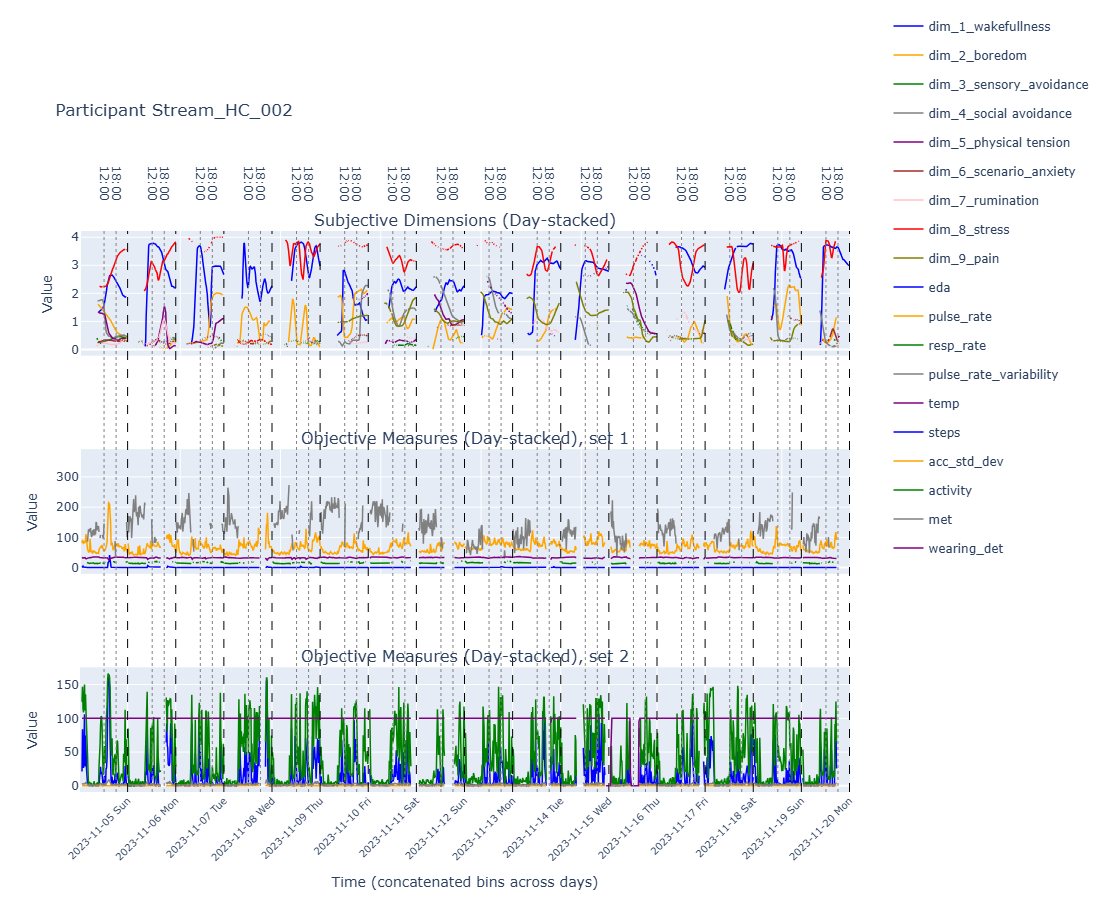

In [74]:
#interactive plotting and incorporating dates and days of the week

# Function to get date and weekday label
def giv_date_and_day(reqYear, reqMonth, reqDay):
    date_obj = datetime(reqYear, reqMonth, reqDay)
    return date_obj.strftime("%Y-%m-%d\n%a")  # Multi-line label: Date + weekday abbrev

# Prepare figure for 3 stacked subplots with shared x-axis
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    subplot_titles=(
        "Subjective Dimensions (Day-stacked)",
        "Objective Measures (Day-stacked), set 1",
        "Objective Measures (Day-stacked), set 2"
    )
)

# Keys and colors
dim_keys = [f"dim_{i}_{name}" for i, name in enumerate([
    "wakefullness", "boredom", "sensory_avoidance", "social avoidance",
    "physical tension", "scenario_anxiety", "rumination", "stress", "pain"
], start=1)]
core_physio_keys = ['eda', 'pulse_rate', 'resp_rate', 'pulse_rate_variability', 'temp']
movement_keys = ['steps', 'acc_std_dev', 'activity', 'met', 'wearing_det']
colors = ['blue', 'orange', 'green', 'grey', 'purple', 'brown', 'pink', 'red', 'olive']

x_offset = 0
day_boundaries = []
day_labels = []
special_bins = [("12.0_12.25", "12:00"), ("18.0_18.25", "18:00")]

partDates = list(norm_res.keys())

for day_idx, day_key in enumerate(partDates):
    day_data = norm_res[day_key]
    first_dim = list(day_data.keys())[0]
    bins = list(day_data[first_dim]['full data'].keys())
    x_vals = np.arange(len(bins)) + x_offset

    # Extract date info from day key to generate tick label
    reqYear = 2000 + int(day_key.split('_')[-2])
    reqMonth = int(day_key.split('_')[-3])
    reqDay = int(day_key.split('_')[-4])
    day_label = giv_date_and_day(reqYear, reqMonth, reqDay)

    day_boundaries.append(x_vals[-1])  # position of day boundary for ticks
    print('day_boundaries = ', day_boundaries)
    day_labels.append(day_label)       # label string for that position

    # Plot dim_keys
    for i, dim in enumerate(dim_keys):
        if dim in day_data:
            y_raw = list(day_data[dim]['full data'].values())
            y_vals = [np.nan if v is None or (isinstance(v, float) and np.isnan(v)) or v == -5000 else v for v in y_raw]
            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals, mode='lines',
                name=dim, legendgroup=dim, showlegend=(day_idx == 6),
                line=dict(color=colors[i % len(colors)], width=1.5)), row=1, col=1)

    # Plot core_physio_keys
    for i, ph in enumerate(core_physio_keys):
        if ph in day_data and "full data" in day_data[ph]:
            y_raw = list(day_data[ph]['full data'].values())
            y_vals = [np.nan if v is None or (isinstance(v, float) and np.isnan(v)) or v == -5000 else v for v in y_raw]
            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals, mode='lines',
                name=ph, legendgroup=ph, showlegend=(day_idx == 6),
                line=dict(color=colors[i % len(colors)], width=1.5)), row=2, col=1)
    
    # Plot movement_keys
    for i, ph in enumerate(movement_keys):
        if ph in day_data and "full data" in day_data[ph]:
            y_raw = list(day_data[ph]['full data'].values())
            y_vals = [np.nan if v is None or (isinstance(v, float) and np.isnan(v)) or v == -5000 else v for v in y_raw]
            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals, mode='lines',
                name=ph, legendgroup=ph, showlegend=(day_idx == 6),
                line=dict(color=colors[i % len(colors)], width=1.5)), row=3, col=1)
    
    # Vertical dashed lines and annotations for special bins
    for special_bin, label in special_bins:
        if special_bin in bins:
            idx = bins.index(special_bin)
            xpos = x_vals[idx]
            fig.add_shape(type="line", x0=xpos, x1=xpos, y0=0, y1=1, yref="paper",
                          line=dict(color="grey", width=1, dash="dot"))
            fig.add_annotation(x=xpos, y=1.05, yref="paper", text=label,
                               showarrow=False, textangle=90, yanchor='bottom')

    x_offset += len(bins)
    print('x_offset = ', x_offset)

# Dashed black vertical day boundary lines
for boundary in day_boundaries:
    fig.add_shape(type="line", x0=boundary, x1=boundary, y0=0, y1=1, yref="paper",
                  line=dict(color="black", width=1, dash="dash"))

participant_title_list = mainfolder.split("\\")[-1].split('_')[0:3]
participant_title = '_'.join(participant_title_list)

fig.update_layout(
    height=900,
    width=1200,
    title_text="Participant " +  participant_title,
    legend=dict(yanchor="middle", y=0.9, xanchor='left', x=1.05),
   
    xaxis3=dict(
        tickmode="array",
        tickvals=day_boundaries,
        ticktext=day_labels,
        tickangle=-45,
        tickfont=dict(size=10),
        showgrid=True,
        zeroline=False
    )
)

# Axis labels
fig.update_xaxes(title_text="Time (concatenated bins across days)", row=3, col=1)
fig.update_yaxes(title_text="Value")

# Save interactive html
#modify focus_folder as required
focus_folder = r'dataclouds_CAM_LMU\Stream_HC_002\all_days'

fig.write_html(os.path.join(focus_folder, "updated_all_days_stacked_fifteen_min_timestitch_interactive_plot_w_days_.html"))

# Show plot
fig.show()
